# Приращение ковариации

## Формулы для аппроксимации дифференциального движения:

#### Формулы для подсчёта общей пройденной дистанции и общего изменения ориентации робота:

$
\Delta s = \frac{\Delta s_r + \Delta s_l}{2}, \quad \Delta \theta = \frac{\Delta s_r - \Delta s_l}{L}
$

где $L$ — расстояние между колёсами, а дельты $s_r$ и $s_l$ — пройденные расстояния правого и левого колеса соответственно.

#### Новое положение робота:
$
x' = \Delta s \cdot \cos\left(\theta + \frac{\Delta \theta}{2}\right) + x, \quad
y' = \Delta s \cdot \sin\left(\theta + \frac{\Delta \theta}{2}\right) + y, \quad
\theta' = \theta + \Delta \theta
$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def differential_drive_motion(pose, delta_s_r, delta_s_l, wheelbase):
    """
    Функция для вычисления нового положения робота с дифференциальным приводом.
    Входные параметры:
    pose - текущее положение робота (x, y, theta),
    delta_s_r - изменение расстояния для правого колеса,
    delta_s_l - изменение расстояния для левого колеса,
    wheelbase - расстояние между колесами.
    Возвращает новое положение робота.
    """
    # Имплементируйте логику здесь

    x, y, theta = pose
    delta_s = (delta_s_r + delta_s_l) / 2
    delta_theta = (delta_s_r - delta_s_l) / wheelbase

    # Вычисляем новое состояние
    x_new = x + delta_s * np.cos(theta + delta_theta / 2)
    y_new = y + delta_s * np.sin(theta + delta_theta / 2)
    theta_new = theta + delta_theta

    return np.array([x_new, y_new, theta_new])

## Приращение ковариации:

#### Якобиан:
$
J = \begin{bmatrix}
1 & 0 & -\Delta s \cdot \sin\left(\theta + \frac{\Delta \theta}{2}\right) \\
0 & 1 & \Delta s \cdot \cos\left(\theta + \frac{\Delta \theta}{2}\right) \\
0 & 0 & 1
\end{bmatrix}
$

#### Ковариация:
$
\Sigma' = J \Sigma J^T + Q
$

In [2]:
def propagate_covariance(covariance_matrix, delta_s_r, delta_s_l, wheelbase):
    """
    Функция для приращения ковариации положения робота.
    Входные параметры:
    covariance_matrix - текущая ковариационная матрица,
    delta_s_r - изменение расстояния для правого колеса,
    delta_s_l - изменение расстояния для левого колеса,
    wheelbase - расстояние между колесами.
    Возвращает новую ковариационную матрицу.
    """
    # Имплементируйте логику здесь
    delta_s = (delta_s_r + delta_s_l) / 2
    delta_theta = (delta_s_r - delta_s_l) / wheelbase
    theta = np.arctan2(covariance_matrix[1, 0], covariance_matrix[0, 0])    

    # Матрица Якоби J
    J = np.array([
        [1, 0, -delta_s * np.sin(theta + delta_theta / 2)],
        [0, 1,  delta_s * np.cos(theta + delta_theta / 2)],
        [0, 0, 1]
    ])

    # Предполагаем матрицу шума Q
    Q = np.diag([0.001, 0.001, 0.001])

    # Новая ковариация
    new_covariance = J @ covariance_matrix @ J.T + Q
    return new_covariance

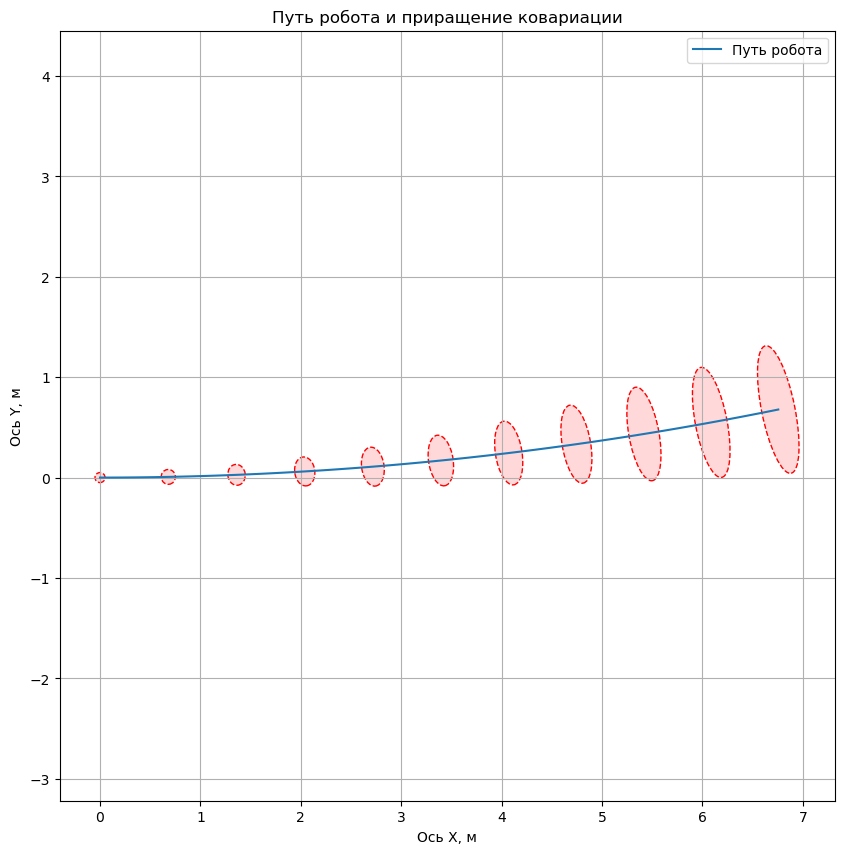

In [3]:
# Инициализация параметров симуляции
timesteps = 100
delta_theta = np.pi / (2 * timesteps)
delta_s_r = 0.069
delta_s_l = 0.067
wheelbase = 1.0

initial_pose = np.array([0, 0, 0]) 
initial_covariance = np.diag([0.01, 0.01, 0.001])

poses = [initial_pose]
covariances = [initial_covariance]

# Имплементируйте логику здесь
for t in range(timesteps):
    current_pose = poses[-1]
    current_covariance = covariances[-1]

    # Обновляем положение
    new_pose = differential_drive_motion(current_pose, delta_s_r, delta_s_l, wheelbase)
    new_covariance = propagate_covariance(current_covariance, delta_s_r, delta_s_l, wheelbase)

    poses.append(new_pose)
    covariances.append(new_covariance)

# Визуализация
plt.figure(figsize=(10, 10))

# Траектория робота
x_coords = [pose[0] for pose in poses]
y_coords = [pose[1] for pose in poses]
plt.plot(x_coords, y_coords, label="Путь робота")

# Отображение эллипсов
for i, (pose, covariance) in enumerate(zip(poses, covariances)):
    if i % 10 == 0:
        tangent_angle = np.arctan2(new_pose[1] - poses[i-1][1], new_pose[0] - poses[i-1][0])
        
        color = '#FFD9D9'
        ellipse = plt.matplotlib.patches.Ellipse(xy=(pose[0], pose[1]), width=np.sqrt(covariance[0, 0]),
                                                 height=np.sqrt(covariance[1, 1]), angle=np.degrees(tangent_angle),
                                                 edgecolor='red', facecolor=color, linestyle='dashed')
        plt.gca().add_patch(ellipse)


plt.xlabel('Ось X, м')
plt.ylabel('Ось Y, м')
plt.title('Путь робота и приращение ковариации')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()